# T04: Outliers and L1 Loss

## Let's start by recalling linear regression!

## Least squares

Recall the least squares (LS) problem for linear regression
$$\hat{\beta} = \underset{\mathbf{\beta}}{\operatorname{argmin}} \sum_{i = 1}^{N} (y_i - x_i^T \beta)^2 = \underset{\mathbf{\beta}}{\operatorname{argmin}} \frac{1}{N}\sum_{i = 1}^{N} (y_i - x_i^T \beta)^2.$$

## A toy example

- Suppose we know the ground truth of $f(\cdot):f(x)=x$

- Now given $\{x_i\}_{i=1}^N$, we have a set of observations $\mathcal{D}=\{(x_i,y_i)\}_{i=1}^N$ with $$y_i=f(x_i) + \epsilon_i,$$ where $\epsilon_i \stackrel{\text { i.i.d. }}{\sim} \mathcal{N}(0,0.1^2)$ is random noise.


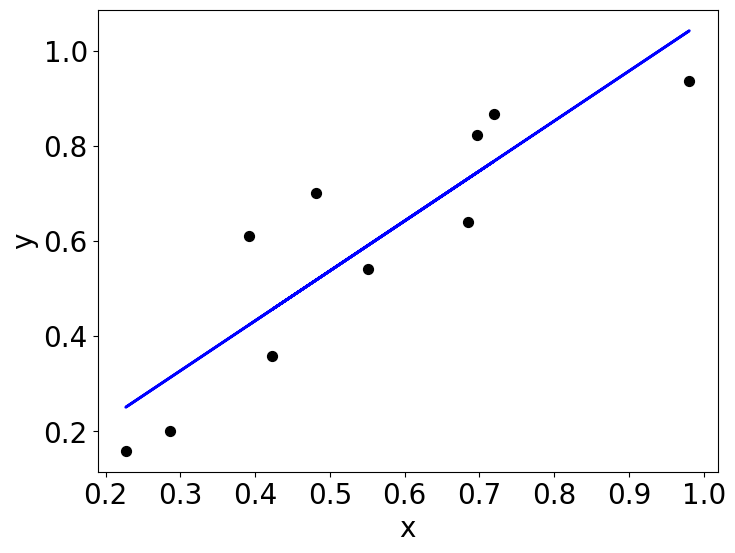

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# set a random seed
np.random.seed(123)
N = 10  # sample size

# data generation
x = np.random.uniform(0, 1, N)
y0 = x  # Ground truth
y_obs = y0 + np.random.normal(0, 0.1, N)  # Add noise, observed data

# create a linear regression model
model = LinearRegression()

# fit the data
model.fit(x.reshape(-1, 1), y_obs)
y_pred = model.predict(x.reshape(-1, 1))

# plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y_obs, s=50, c='black')  # scatter plot
plt.plot(x, y_pred, color='blue', linewidth=2, label='Fitted line')
plt.ylabel('y', fontsize=20)
plt.xlabel('x', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# What if there exists an outlier?


## Add an outlier


- We follow the above problem setting.

- But add an outlier 
$$(x, y, y_{\text{obs}}) = (0.9, 0.9, -2),$$ of which the noise is extremely large.
This situation is rare, but the probability is not zero!

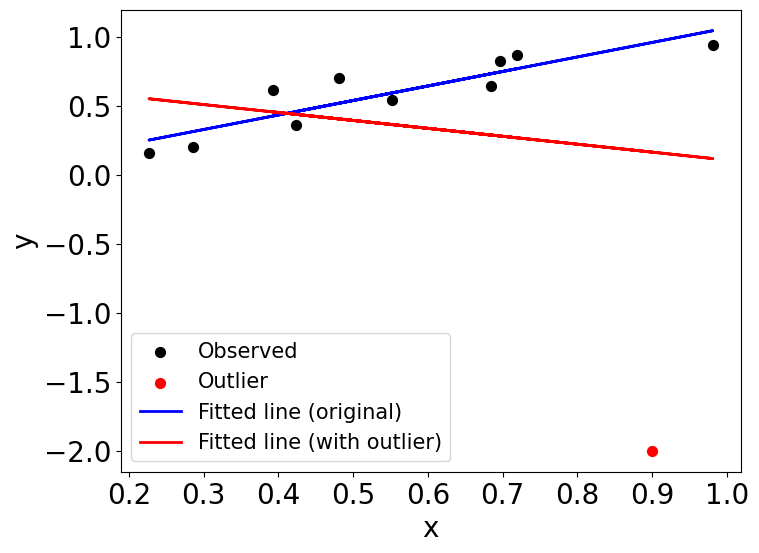

In [2]:
# add an outlier
x_ol = np.append(x, 0.9)
y0_ol = np.append(y0, 0.9)
y_obs_ol = np.append(y_obs, -2)

# fit data with the outlier
model.fit(x_ol.reshape(-1, 1), y_obs_ol)
y_pred_ol = model.predict(x_ol.reshape(-1, 1))

# plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y_obs, s=50, c='black', label='Observed')
plt.scatter([0.9], [-2], s=50, c='red', label='Outlier')

plt.plot(x, y_pred, color='blue', linewidth=2, label='Fitted line (original)')
plt.plot(x_ol, y_pred_ol, color='red', linewidth=2, label='Fitted line (with outlier)')

plt.ylabel('y', fontsize=20)
plt.xlabel('x', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.show()

## Brief summary of squared loss

Pros

- Natural, intuitive (Euclidean distance)

- Closed form solution

Con

- Not robust to outliers, equal weights to all data (assumes Gaussian distributed residual)

# Let's consider a more robust loss function!

## $l_1$ loss

- $l_2$ norm and $l_1$ norm
$$||x||_2 = \left( \sum_{j = 1}^{p} x_j^2\right)^{\frac{1}{2}}, \quad ||x||_1 = \sum_{j = 1}^{p} |x_j|.$$

- $l_2$ loss and $l_1$ loss
$$\mathcal{L}_2 = \sum_{i = 1}^{N} (y_i - x_i^T \beta)^2 = ||y - X \beta||_2^2, \quad \\
\mathcal{L}_1 = \sum_{i = 1}^{N} |y_i - x_i^T \beta| = ||y - X \beta||_1.$$


## Why is $l_1$ more robust?

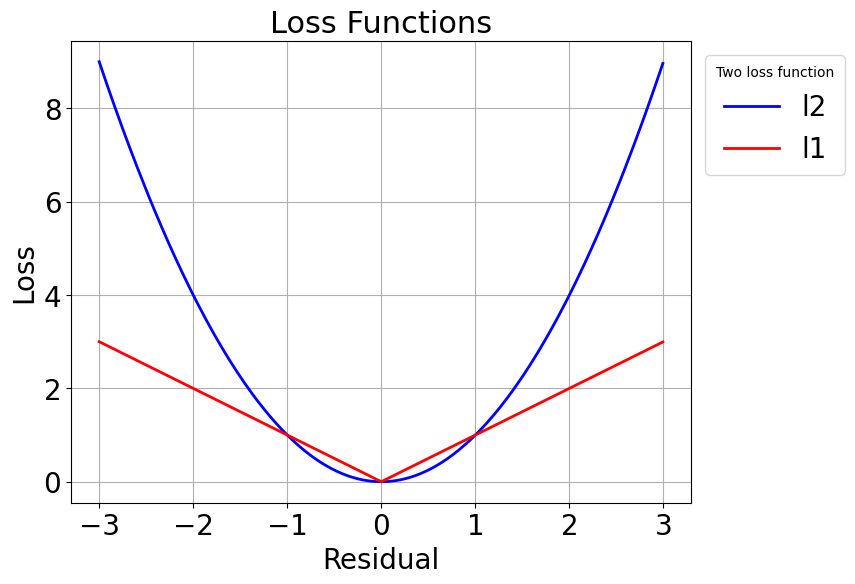

In [3]:
# data generation
r = np.random.uniform(-3, 3, 500)
r = np.sort(r)
l1 = np.abs(r)
l2 = r**2

# plot
plt.figure(figsize=(8, 6))
plt.plot(r, l2, color='blue', linewidth=2, label='l2')  # l2 loss function
plt.plot(r, l1, color='red', linewidth=2, label='l1')    # l1 loss function

plt.xlabel('Residual', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title='Two loss function', fontsize=20, bbox_to_anchor=(1,1))
plt.title('Loss Functions', fontsize=22)
plt.grid()
plt.show()

### However, the bad news is that $l_1$ loss function is not differentiable :(

# Let's relax it!

## MM algorithm <sup>*</sup>

The "MM" stands for “Majorization-Minimization” or “Minorization-Maximization”.
In the following, "MM" refers to "Majorization-Minimization".

- Consider the following presumably difficult optimization problem
$$\underset{\mathbf{x}}{\operatorname{minimize}} f(\mathbf{x}) \\
\text{ subject to } \mathbf{x} \in \mathcal{X},$$
with $\mathcal{X}$ being the feasible set and $f(\mathbf{x})$ being continuous.
- Idea: successively minimize a more managable surrogate function $u\left(\mathbf{x}, \mathbf{x}^k\right)$
$$
\mathbf{x}^{k+1}=\arg \min _{\mathbf{x} \in \mathcal{X}} u\left(\mathbf{x}, \mathbf{x}^k\right),
$$
hoping the sequence of minimizers $\left\{\mathbf{x}^k\right\}$ will converge to optimal $\mathbf{x}^{\star}$.

[*] Materials are form ELEC 5470 / IEDA 6100A Convex Optimization, Prof. Daniel P. Palomar, ECE, HKUST.

## Iterative algorithm

Suppose $x_0$ is the initial point, in $k$-th step, we want $x_{k-1} \rightarrow x_{k}$.

### After k-th step
![k-th step](mm_k.png)

### k+1-th step
![k+1-th step](mm_k1.png)

### k+2-th step
![k+2-th step](mm_k2.png)

## Construction rule of the surrogate / majorizer function <sup>*</sup>

$$
{
\begin{align}
u(\mathbf{y}, \mathbf{y}) & = f(\mathbf{y}), \quad \forall \mathbf{y} \in \mathcal{X} \\
u(\mathbf{x}, \mathbf{y}) & \geq f(\mathbf{x}), \quad \forall \mathbf{x}, \mathbf{y} \in \mathcal{X} \\
\left.u^{\prime}(\mathbf{x}, \mathbf{y} ; \mathbf{d})\right|_{\mathbf{x}=\mathbf{y}} & = f^{\prime}(\mathbf{y} ; \mathbf{d}), \quad \forall \mathbf{d} \text{ with } \mathbf{y}+\mathbf{d} \in \mathcal{X} \\
u(\mathbf{x}, \mathbf{y}) & \text{ is continuous in } \mathbf{x} \text{ and } \mathbf{y}
\end{align}
}
$$

### Question: how to construct $u\left(\mathbf{x}, \mathbf{x}^k\right)$ ?


### Answer: that's more like an art :)


### Luckily, the MM algorithm for $l_1$-norm minimization has been well established!

## Majorizer for $l_1$-norm

- Consider the following quadratic majorizer of $f(t)=|t|$ for $t \neq 0$ (for simplicity we ignore this case)
$$
u\left(t, t^k\right)=\frac{1}{2\left|t^k\right|}\left(t^2+\left(t^k\right)^2\right) .
$$

- It is a valid majorizer since it is continuous, and
$$u\left(t, t^k\right) \geq f(t),$$
$$u\left(t^k, t^k\right)=f(t),$$ 
$$\frac{d}{d t} u\left(t^k, t^k\right)=\frac{d}{d t} f\left(t^k\right).$$

## Majorizer for $l_1$-norm

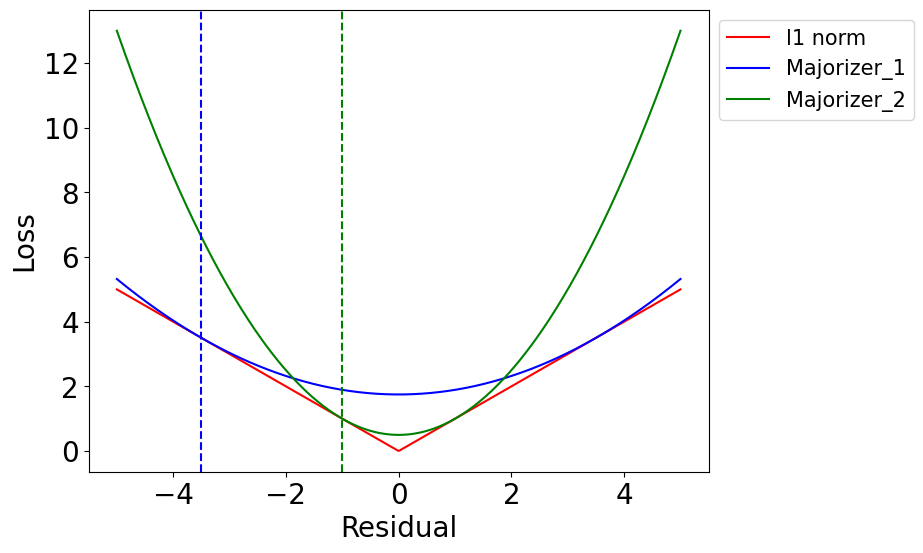

In [4]:
t = np.linspace(-5, 5, 500)
l1 = np.abs(t)

t_k_1 = -3.5
l1_maj_1 = (t**2 + t_k_1**2) / (2 * abs(t_k_1))

t_k_2 = -1
l1_maj_2 = (t**2 + t_k_2**2) / (2 * abs(t_k_2))

plt.figure(figsize=(8, 6))
plt.plot(t, l1, label='l1 norm', color='red', linewidth=1.5)
plt.plot(t, l1_maj_1, label='Majorizer_1', color='blue', linewidth=1.5)
plt.plot(t, l1_maj_2, label='Majorizer_2', color='green', linewidth=1.5)
plt.axvline(x=t_k_1, color='blue', linestyle='--', linewidth=1.5)
plt.axvline(x=t_k_2, color='green', linestyle='--', linewidth=1.5)

plt.xlabel('Residual', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, bbox_to_anchor=(1,1))
plt.show()

## Reweighted LS for $l_1$-norm minimization

- Now we can apply it to the $\ell_1$-norm: a quadratic majorizer of $f(\beta) = \|X \beta - y\|_1$ is
$$
u \left(\beta, \beta^k\right) = \sum_{i=1}^N \frac{1}{2 \left| \left[ X \beta^ { k } - y \right]_i \right| } \left( [X \beta - y]_i^2 + \left( \left[ X \beta^ { k } - y \right]_i \right)^2 \right).
$$
- Now that we have the majorizer, we can write the MM iterative algorithm for $k=0,1, \ldots$ as
$$
\underset{\beta}{\operatorname{minimize}} ||(X \beta - y) \odot w^k ||_2^2,
$$
where $w_i^k = \sqrt{\frac{1}{2\left|\left[ X \beta^ { k } - y \right]_i \right|}}$.

---

## Algorithm

- Set $k = 0$ and initialize with a feasible point $\beta^0$

- **repeat**
  
  - $w_i^k \leftarrow \sqrt{\frac{1}{2\left|\left[ X \beta^ { k } - y \right]_i \right|}}$
  
  - Update $\beta^{k+1} \leftarrow \underset{\beta}{\operatorname{argmin}} \left\|(X \beta - y) \odot w^k \right\|_2^2$
  
  - $k \leftarrow k + 1$
  
- **until** convergence

- **return** $\beta^k$

---

## Implementation (first 5 steps)

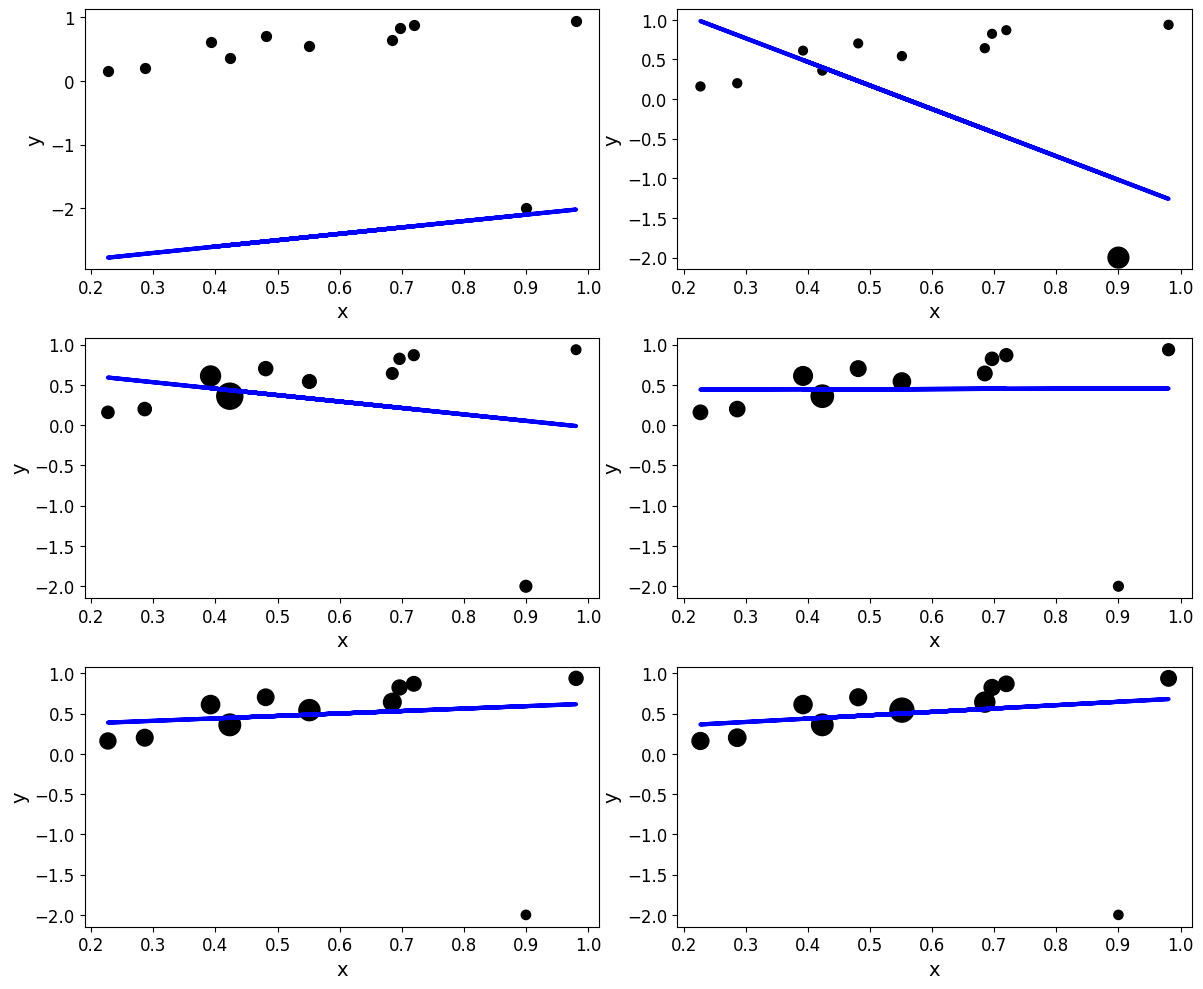

In [5]:
import pandas as pd
import statsmodels.api as sm

df = pd.DataFrame({'y': y_obs_ol, 'x': x_ol})

# Initialization
#beta_0 = np.random.normal(1) # Initialize intercept
#beta_1 = np.random.normal(1) # Initialize slope
beta_0 = -3  # To demonstrate, we fit beta_0 = -3
beta_1 = 1   # To demonstrate, we fit beta_1 = 1

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

axes[0].scatter(df['x'], df['y'], s=50, c='black')    
axes[0].plot(df['x'], beta_0 + beta_1 * df['x'], color='blue', linewidth=3)
axes[0].set_xlabel('x', fontsize=14)
axes[0].set_ylabel('y', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)

for k in range(1, 6):  # Here we only repeat 5 times
    weights = np.sqrt(1 / (2 * np.abs(beta_0 + df['x'] * beta_1 - df['y'])))
    model = sm.WLS(df['y'], sm.add_constant(df['x']), weights=weights).fit() # Reweighted LS for l1 norm minimization

    # update intercept and slope
    beta_0, beta_1 = model.params
    
    #axes[k].scatter(df['x'], df['y'], s=50, c='black')
    sizes = weights * 100  # visualize according to the weight of each point
    axes[k].scatter(df['x'], df['y'], s=sizes, c='black')    
    axes[k].plot(df['x'], beta_0 + beta_1 * df['x'], color='blue', linewidth=3)
    axes[k].set_xlabel('x', fontsize=14)
    axes[k].set_ylabel('y', fontsize=14)
    axes[k].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

## Full implementation

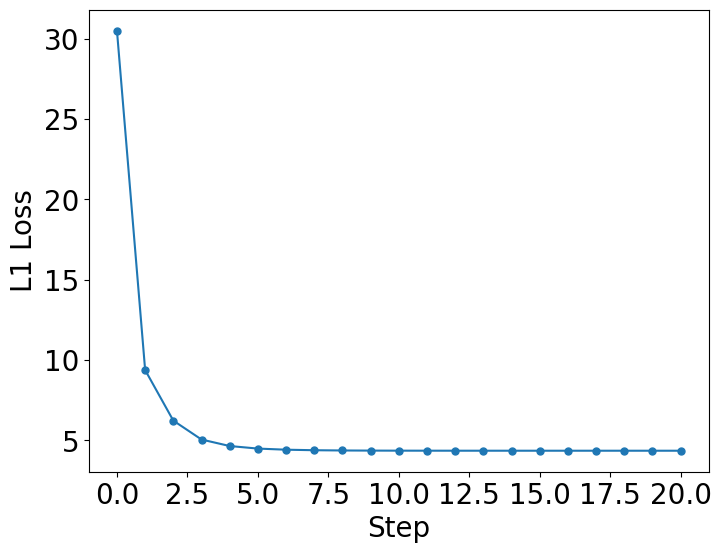

In [6]:
# Initialization and parameter setting
df = pd.DataFrame({'y': y_obs_ol, 'x': x_ol})

#beta_0 = np.random.normal(1) # Initialize intercept
#beta_1 = np.random.normal(1) # Initialize slope
beta_0 = -3  # To demonstrate, we fit beta_0 = -3
beta_1 = 1   # To demonstrate, we fit beta_1 = 1

tol = 1e-6 # Convergence tolerance / criterion
iter_max = 5000 # Maximum number of iterations

# l1 norm minimization

l1_loss = [np.sum(np.abs(beta_0 + x_ol * beta_1 - y_obs_ol))] # l1 loss at initial point

for k in range(iter_max):
    weights = np.sqrt(1 / (2 * np.abs(beta_0 + x_ol * beta_1 - y_obs_ol)))
    model = sm.WLS(df['y'], sm.add_constant(df['x']), weights=weights).fit() # Reweighted LS for l1 norm minimization
    
    beta_0, beta_1 = model.params # update intercept and slope
    l1_loss_current = np.sum(np.abs(beta_0 + x_ol * beta_1 - y_obs_ol))
    l1_loss.append(l1_loss_current) # l1 loss in the current step

    # check convergence
    if abs((l1_loss[k + 1] - l1_loss[k]) / l1_loss[k]) < tol:
        break

# plot l1 loss
plt.figure(figsize=(8, 6))
plt.plot(range(len(l1_loss)), l1_loss, marker='o', markersize=5, linewidth=1.5)
plt.xlabel('Step', fontsize=20)
plt.ylabel('L1 Loss', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## Subgradient method <sup>*</sup>

We say a vector $g \in \mathbf{R}^n$ is a subgradient of $f: \mathbf{R}^n \rightarrow \mathbf{R}$ at $x \in \operatorname{dom} f$ if for all $z \in \operatorname{dom} f$,
$$
f(z) \geq f(x)+g^T(z-x).
$$

The subgradient of $l_1$-norm can be taken as
$$g_i= 
\begin{equation}
\begin{cases}+1 & x_i>0 \\ 
-1 & x_i<0 \\ 
0 & x_i=0\end{cases}
\end{equation}.$$


**Note**: subgradient method is **not** a descent method, and negative subgradient is **not** always a descent direction!

[*] Materials are from [Subgradients](https://see.stanford.edu/materials/lsocoee364b/01-subgradients_notes.pdf) and [Subgradient Methods](https://web.stanford.edu/class/ee392o/subgrad_method.pdf), EE364b, Stephen Boyd and Lieven Vandenberghe, Stanford University.

## Implementation

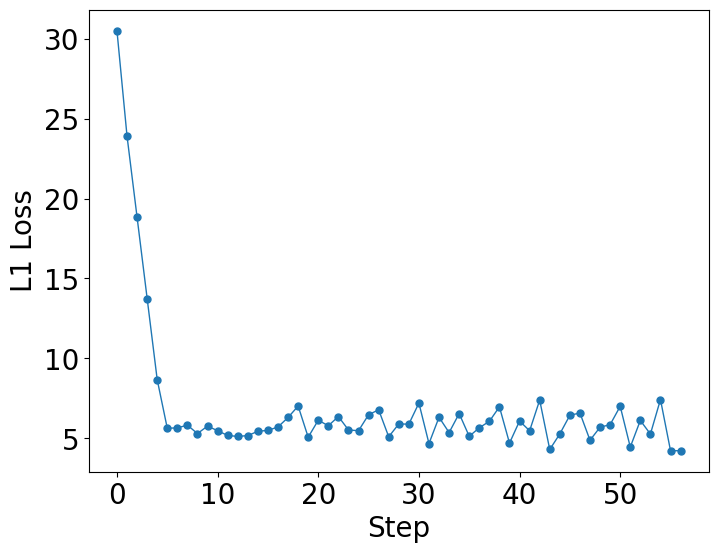

In [7]:
# Initialization and parameter setting

#beta_0 = np.random.normal(1) # Initialize intercept
#beta_1 = np.random.normal(1) # Initialize slope
beta_0 = -3  # To demonstrate, we fit beta_0 = -3
beta_1 = 1   # To demonstrate, we fit beta_1 = 1
beta = np.array([beta_0, beta_1])

step_size = 0.05 # Try different step size, e.g., 0.1 and 0.01, and see what will happen!
tol = 1e-3 # Convergence tolerance / criterion
iter_max = 5000 # Maximum number of iterations

X = np.vstack((np.ones(len(x_ol)), x_ol)).T

# l1 norm minimization
l1_loss = [np.sum(np.abs(beta[0] + x_ol * beta[1] - y_obs_ol))] # l1 loss at initial point

for k in range(iter_max):
    r = y_obs_ol - X @ beta  # residual
    subgrad = X.T @ np.sign(r) # subgradient

    beta = beta + step_size * subgrad  # update beta

    l1_loss_current = np.sum(np.abs(beta[0] + x_ol * beta[1] - y_obs_ol)) # l1 loss in the current step
    l1_loss.append(l1_loss_current)

    # check convergence
    if abs((l1_loss[k + 1] - l1_loss[k]) / l1_loss[k]) < tol:
        break

# plot l1 loss
plt.figure(figsize=(8, 6))
plt.plot(range(len(l1_loss)), l1_loss, marker='o', markersize=5, linewidth=1)
plt.xlabel('Step', fontsize=20)
plt.ylabel('L1 Loss', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()